# Doc 1 Curb Weight Data

Curb weight data source: https://xl.16888.com/style-202503-202503-1.html
- Vehicle type coverage: micro, small, compact, mid-size, large, luxury, MPV, and SUV.
- Not include imported models.
- Car sales data from 2007 to present.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1 Extraction

In [ ]:
import pandas as pd
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
# automate download
from selenium.webdriver.chrome.service import Service
driver_path=ChromeDriverManager().install()

def init_driver():
    service = Service(driver_path)
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])
    prefs = {"profile.managed_default_content_settings.images": 2, 'permissions.default.stylesheet': 2}
    chrome_options.add_experimental_option("prefs", prefs)
    chrome_options.add_argument('lang=zh_CN.utf-8')
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def get_model_year(year):
    """
    Get model sales data of one year.
    """
    url = 'https://xl.16888.com/style-%d01-%d12-1.html' % (year, year)
    driver = init_driver()
    try:
        driver.get(url)
    except:
        print("No Data.")
    wait = WebDriverWait(driver, 10)
    # define data file
    data = []
    page = 1
    # iterate pages
    while True:
        # get items
        table = driver.find_element(By.CSS_SELECTOR, 'body > div:nth-child(5) > div.xl-section.clr > div.xl-section-r.fr > div > div.xl-table-view > div.xl-table-data > table > tbody')
        rows = table.find_elements(By.TAG_NAME, 'tr')
        for row in rows:
            # sales data
            cells = row.find_elements(By.TAG_NAME, 'td')
            line = [cell.text for cell in cells[:-1]]
            if line:
                model = line[1]
                sale = line[2]
                data.append([model, sale])
        page += 1
        try:
            # wait for next page botton
            next_page = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.lineBlock.next')))
            # click next page
            next_page.click()
            # wait for next page
            wait.until(EC.staleness_of(next_page))
        except:
            print('All pages done!')
            break
    driver.close()
    df = pd.DataFrame(data, columns=['model', 'sales'])
    df['class'] = None
    df['fuel'] = None
    df['weight'] = None
    df['frontB'] = None
    df['rearB'] = None
    df['link'] = None
    return df

def get_model_link(df):
    """
    Get config link of models.
    """
    url = 'https://auto.16888.com/'
    driver = init_driver()
    try:
        driver.get(url)
    except:
        print("No Data.")
    wait = WebDriverWait(driver, 10)
    for i in tqdm(range(df.shape[0])):
        # get link
        line = df.loc[i]
        try:
            link = driver.find_element(By.LINK_TEXT, line['model'])
            link = link.get_attribute('href')
            df.loc[i, 'link'] = link
        except:
            pass
    driver.close()
    return df

def get_model_config(df, year):
    """
    Get config data of models.
    """
    df['year'] = year
    # initialize driver
    for i in tqdm(range(df.shape[0])):
        link = df.loc[i, 'link']
        if link:
            n = 0
            while True:
                n += 1
                try:
                    driver = init_driver()
                    driver.get(link)
                    break
                except:
                    if n <= 10:
                        print("Create driver failed. Retry...")
                    else:
                        break
            if n > 10:
                continue
        else:
            continue
        # get config data
        try:
            link = driver.find_element(By.LINK_TEXT, '参数配置')
            link.click()
        except:
            continue
        # select a year
        find_status = 0
        for y in list(range(year, 2025, 1)):
            try:
                type_year = driver.find_element(By.XPATH, '//*[@id="Year%d"]' % y) 
                type_year.click()
                find_status = 1
                break
            except:
                pass
        if find_status == 0:
            for y in list(range(year, 2000, -1)):
                try:
                    type_year = driver.find_element(By.XPATH, '//*[@id="Year%d"]' % y) 
                    type_year.click()
                    find_status = 1
                    break
                except:
                    pass
        if find_status == 1:
            config_table = driver.find_element(By.ID, 'config_main')  # data table
            config_data = config_table.text
            # config data extraction
            config_data = config_data.split('\n')
            car_class = config_data[5].split()[1:]
            fuel_type = config_data[49].split()[1:]
            weight = config_data[26].split()[1:]
            front_brake = config_data[66].split()[1:]
            rear_brake = config_data[67].split()[1:]
            # save
            df.loc[i, 'fuel'] = str(fuel_type)
            df.loc[i, 'class'] = str(car_class)
            df.loc[i, 'weight'] = str(weight)
            df.loc[i, 'frontB'] = str(front_brake)
            df.loc[i, 'rearB'] = str(rear_brake)
        else:
            pass
        driver.close()
    return df

In [ ]:
# aggregate function
def get_sales(year):
    df = get_model_year(year)
    df = get_model_link(df)
    df = get_model_config(df, year)
    return df

In [ ]:
# crawling data from 2007 to 2025
for year in range(2007,2025,1):
    try:
        sales = get_model_year(int(year))
        sales = get_model_link(sales)
        sales = get_model_config(sales, int(year))
        sales.to_excel("data/car_sale_%d.xlsx" % year, index=False)
    except:
        pass

## 2 Processing

In [10]:
# processing functions
# for model with multiple parameters, we choose the most common or typical set of params
def get_basic_weight(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = [s for s in data if any(char.isdigit() for char in s)]
    if data:
        data = max(data,key=data.count)
        return int(data)
    else:
        return None

def get_basic_brake(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if '通风盘式' in data:
        return 'ventiled'
    elif '盘式' in data:
        return 'disc'
    elif '鼓式' in data:
        return 'drum'
    else:
        return None

car_map = {
    'SUV': 'SUV', 
    'MPV': 'MPV',
    '微型车': 'microcar',
    '小型车': 'small car',
    '紧凑型车': 'compact car',
    '中型车': 'mid-size car',
    '中大型车': 'large car',
    '大型车': 'luxury car',
    '跑车': 'sports car',
    '不限': None
}

def get_class(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    for k,v in car_map.items():
        if k in data:
            return v

def get_fuel_type(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if '汽油' in data:
        return 'ICEV'
    elif '纯电动' in data:
        return 'BEV'
    elif '插电' in data:
        return 'PHEV'
    elif '混' in data:
        return 'HEV'
    elif '增程' in data:
        return 'EREV'
    else:
        return 'others'

In [11]:
import pandas as pd

# aggregate
sales = pd.DataFrame([])
for year in range(2007, 2025, 1):
    raw = pd.read_excel('data/sales data 2007_2024/car_sale_%d.xlsx' % int(year))
    raw.reset_index(drop=True, inplace=True)
    sale = raw.copy()
    sale['weight'] = sale['weight'].map(get_basic_weight)
    sale['frontB'] = sale['frontB'].map(get_basic_brake)
    sale['rearB'] = sale['rearB'].map(get_basic_brake)
    sale['fuel'] = sale['fuel'].map(get_fuel_type)
    sale['class'] = sale['class'].map(get_class)
    sale['year'] = int(year)
    sales = pd.concat([sales, sale])
# sales.dropna(inplace=True)

In [12]:
sales.head()

,model,sales,class,fuel,weight,frontB,rearB,link,year
0,赛马,849104,small car,ICEV,1180.0,disc,drum,https://www.16888.com/57570/,2007
1,远景,813266,compact car,ICEV,1200.0,ventiled,disc,https://www.16888.com/57609/,2007
2,路宝,707202,microcar,ICEV,920.0,disc,drum,https://www.16888.com/57568/,2007
3,圣达菲00,691764,SUV,ICEV,1665.0,ventiled,disc,https://www.16888.com/127145/,2007
4,伊兰特,607008,compact car,ICEV,1250.0,ventiled,disc,https://www.16888.com/58009/,2007


<Axes: title={'center': 'Car Sales in China from 2007 to 2024'}, xlabel='year'>

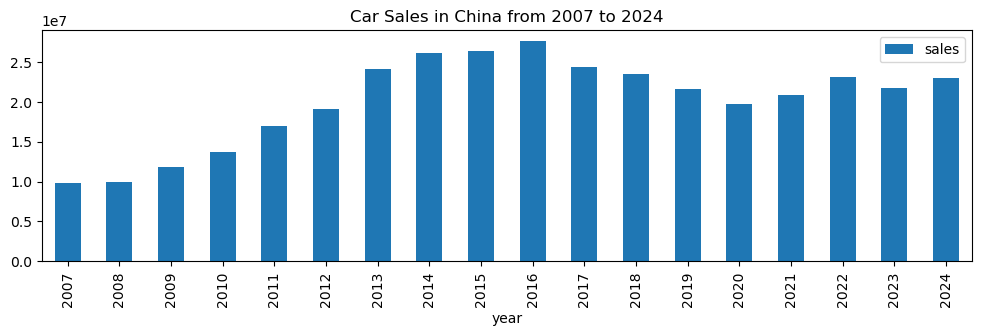

In [17]:
sales[['year', 'sales']].groupby(by=['year']).sum().plot(kind='bar', figsize=(12,3), title='Car Sales in China from 2007 to 2024')

In [ ]:
# sales.to_excel('data/car_sales_2007_2024.xlsx', index=False)

## 3 Analysis

In [2]:
sales = pd.read_excel('data/car_sales_2007_2024.xlsx')

In [3]:
# expand according to sales
expanded_data = []
for index, row in sales.iterrows():
    expanded_data.extend([(row['model'], row['sales'], row['class'], row['fuel'], row['weight'], row['frontB'], row['rearB'], row['year'])] * int(row['sales'] / 100))
expanded_sales = pd.DataFrame(expanded_data, columns=sales.columns[:-2].to_list() + ['year'])

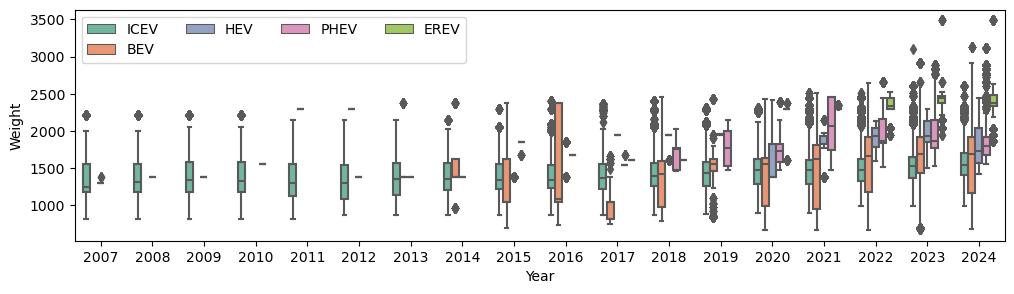

In [16]:
plt.figure(figsize=(12,3))
sns.boxplot(
    x='year', 
    y='weight', 
    hue='fuel', 
    hue_order=['ICEV', 'BEV', 'HEV', 'PHEV', 'EREV'],
    data=expanded_sales, 
    palette='Set2',
    width=0.7
)

plt.legend(loc=2, ncols=4)
plt.xlabel('Year')
plt.ylabel('Weight')
plt.show()

In [9]:
# Calculate penetration rate for each electric vehicle type by year
ev_types = ['BEV', 'HEV', 'PHEV', 'EREV', 'others']
ev_penetration = expanded_sales[expanded_sales['fuel'].isin(ev_types)].groupby(['year', 'fuel']).size().unstack(fill_value=0)
ev_penetration = ev_penetration.div(ev_penetration.sum(axis=1), axis=0)
ev_penetration

fuel,BEV,EREV,HEV,PHEV,others
year,,,,,
2007,0.000000,0.000000,0.155886,0.000000,0.844114
2008,0.000000,0.000000,0.028865,0.000000,0.971135
2009,0.000000,0.000000,0.000185,0.000000,0.999815
2010,0.000000,0.000000,0.000000,0.210965,0.789035
2011,0.000290,0.000000,0.000000,0.000000,0.999710
2012,0.000624,0.000000,0.000936,0.000000,0.998440
2013,0.070561,0.000000,0.009486,0.000000,0.919953
2014,0.034915,0.000000,0.039690,0.000000,0.925395
2015,0.043225,0.000000,0.247689,0.302157,0.406929


In [7]:
# Calculate penetration rate of each fuel type in each year
penetration_rate = expanded_sales.groupby(['year', 'fuel']).size().unstack(fill_value=0)
penetration_rate = penetration_rate.div(penetration_rate.sum(axis=1), axis=0)
penetration_rate

fuel,BEV,EREV,HEV,ICEV,PHEV,others
year,,,,,,
2007,0.000000,0.000000,0.008334,0.946540,0.000000,0.045127
2008,0.000000,0.000000,0.002069,0.928326,0.000000,0.069605
2009,0.000000,0.000000,0.000017,0.909156,0.000000,0.090827
2010,0.000000,0.000000,0.000000,0.926505,0.015505,0.057990
2011,0.000024,0.000000,0.000000,0.918409,0.000000,0.081567
2012,0.000084,0.000000,0.000125,0.865963,0.000000,0.133828
2013,0.001758,0.000000,0.000236,0.975088,0.000000,0.022918
2014,0.001258,0.000000,0.001430,0.963977,0.000000,0.033336
2015,0.001964,0.000000,0.011253,0.954568,0.013728,0.018487


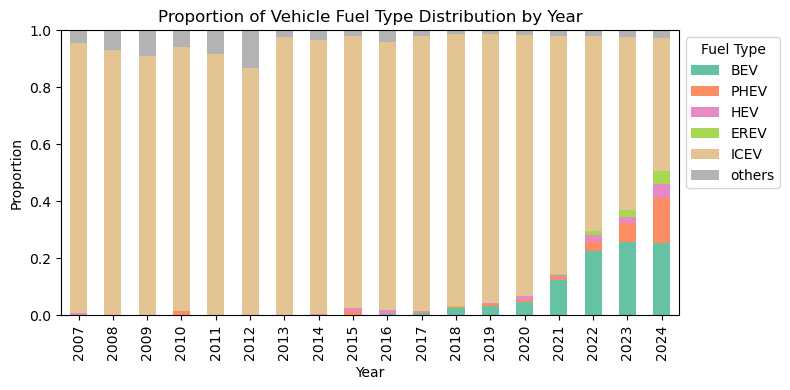

In [24]:
# Normalize to proportions
fuel_type_data = expanded_sales.groupby(['year', 'fuel']).size().unstack(fill_value=0)
fuel_type_data_normalized = fuel_type_data.div(fuel_type_data.sum(axis=1), axis=0)
fuel_type_data_normalized = fuel_type_data_normalized[['BEV', 'PHEV', 'HEV', 'EREV', 'ICEV', 'others']]

# Plot the stacked barplot
fuel_type_data_normalized.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2')
plt.title('Proportion of Vehicle Fuel Type Distribution by Year')
plt.xlabel('Year')
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.legend(title='Fuel Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()